Turn attention to classification systems

- MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees


In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

DESCR key describes dataset + data key conatins array w/ one row per instance and one column per feature + target key contains array with labels.

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

To view one of the digits: grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function

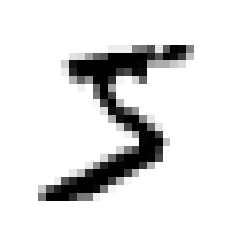

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show();

In [6]:
# where if we check the label, we have
y[0]

'5'

In [7]:
import numpy as np
# define it as integer
y = y.astype(np.uint8)

In [8]:
# define training set (first 60,000 images) and test set (last 10,000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

note that training set already shuffled -> ideal for cross-validation

### Training Binary Classifier

define a "5" / "not-5" classifier -> create target vectors for classification task

In [9]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [10]:
# Stochastic Gradient Descent classifier -> train on dataset
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# try it on our digit above (which was a five)
sgd_clf.predict([some_digit])
# it works! t indeed detects that its a number 5

array([ True])

### Performance Measures

#### Measuring accuracy using cross-validation

At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# performs stratified sampling -> folds w/ representative ratio of each class
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565, and 0.96495

0.9559
0.9559
0.96565


using cross validation score w/ 3 folds

above 95% accuracy?????

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [16]:
# let's try dumb classifier classifying ALL images in "not-5" class

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

accuracy is a **bad** measure of performance because the reason why accuracy is above 90% is because there are less than 10% of 5s!!

#### Confusion matrix

we're not using the test set, we will use the cross_val_predict function

cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold
- clean (model that never saw the data during training) prediction for each instance in the training set 

each column = predicted class

each row = actual class

The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives)

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
# imagine a perfect classifier
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Metrics

more conscise way of describing a confusion matrix

#### Precision

$precision = \frac{TP}{TP+FP}$ -> true positives and false positives

usually used combined with recall (alone doesnt give us much info)

#### Recall

$recall = \frac{TP}{TP+FN}$


In [20]:
from IPython.display import Image
Image(url= "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0302.png", width=500, height=500)

In [21]:
# SL has function to calculate precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1522)
print(recall_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1325)

0.8370879772350012
0.6511713705958311


doesnt look as good as before! When it claims an image represents a 5, it is correct only 72.9% of the time. Moreover, it only detects 75.6% of the 5s.

can also use **f1 score** -> simple way of comparing classifiers
- Harmonic mean of precision and recall

the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

$$F_1 = \frac{TP}{TP + \frac{FN+FP}{2}}$$

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

#### precision/recall trade-off

how does SGDC classify?
- computes score based on decision function
- if greater than threshold -> POSITIVE

figure below shows a few digits positioned from the lowest score on the left to the highest score on the right.

lowering the threshold increases recall and reduces precision.

In [23]:
from IPython.display import Image
Image(url= "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0303.png", width=500, height=500)

In [28]:
# can access decision scores used to make predictions -> decision_function
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold) # RETURNS TRUE
y_some_digit_pred

[2164.22030239]


array([ True])

In [27]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

raising threshold indeed decreases recall -> from TP to FN

how do we know which threshold to use??????
use cross validation but we want to return decision scores INSTEAD of predictions!!

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


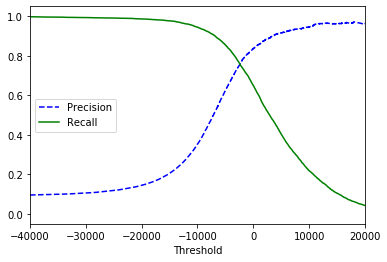

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlim(-40000, 20000)
    plt.legend()
    plt.xlabel("Threshold")
    # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Text(0, 0.5, 'Precision')

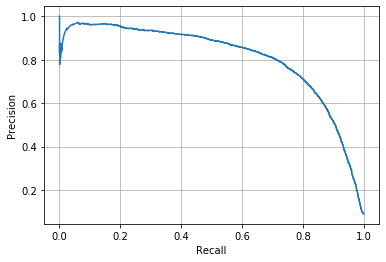

In [42]:
# can also plot precision vs recall!!
plt.plot(recalls, precisions)
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision");

depending on the project, you might prioritise precision OR recall!

for example: search for the lowest threshold that gives you at least 90% precision (np.argmax() will give you the first index of the maximum value, which in this case means the first True value):

In [47]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

y_train_pred_90 = (y_scores >= threshold_90_precision)
print(y_train_pred_90)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

[False False False ...  True False False]
0.9000345901072293
0.4799852425751706


#### ROC curve

